In [1]:
import cv2
from itertools import combinations
import os
import sys
import time
from typing import Optional
from unicodedata import bidirectional

from imblearn.over_sampling import SMOTE
from keras import models
from keras._tf_keras.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras._tf_keras.keras.metrics import MeanAbsoluteError, Accuracy, Precision, Recall, MeanSquaredError
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.optimizers import Adam , RMSprop, Nadam
from keras._tf_keras.keras.preprocessing.sequence import pad_sequences 
from keras._tf_keras.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Masking, InputLayer
from keras._tf_keras.keras.regularizers import L1L2, L1, L2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix
from scipy.stats import skew, kurtosis
from sklearn.calibration import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2
import mediapipe as mp
import io
import time
from collections import Counter
from itertools import combinations
import joblib

from engineering import feature_engineering as fe

In [2]:
model = models.load_model(r"model_dr1722019647575053700.keras")
class_labels = pd.read_csv("class_labels.csv")["gesture"].tolist()
preprocessor = joblib.load("preprocessor.pkl")
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistics = mp.solutions.holistic
holistics = mp_holistics.Holistic(static_image_mode=False, min_detection_confidence=0.65, min_tracking_confidence=0.8)


pd.set_option("display.max_columns", None) # show all cols
pd.set_option("expand_frame_repr", False) 

In [7]:
def calculate_hand_motion_features(df: pd.DataFrame, landmark_cols: list) -> pd.DataFrame:
    df_copy = df.copy()
    _ = fe.calculate_temporal_features(df_copy, landmark_cols)
    df_combined = df_copy.loc[:, ~df_copy.columns.duplicated()] # removed any duplicate columns
    return df_combined

def predict(landmark_seq, frame_rate, frame_width, frame_height, gesture_action=""):
    header = (
            [f'{coord}_{i}' for i in range(468) for coord in ('hx', 'hy', 'hz')]+
            [f'{coord}_{i}' for i in range(33) for coord in ('px', 'py', 'pz', "pose_visibility")]+
            [f'{coord}_{i}' for i in range(21) for coord in ('lx', 'ly', 'lz')]+
            [f'{coord}_{i}' for i in range(21) for coord in ('rx', 'ry', 'rz')]+
            ["frame_rate", "frame_width", "frame_height", "frame", "gesture_index"]
        )
    
    data = [
        frame_data + [frame_rate, frame_width, frame_height, i, time.time_ns()]  for i, frame_data in enumerate(landmark_seq)
    ]

    df = pd.DataFrame(data, columns=header)
    
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, columns=df.columns.tolist(), index=False)
    csv_buffer.seek(0)

    input_df= pd.read_csv(csv_buffer)
    landmark_columns = [f"{col}" for col in input_df.columns if col.startswith(("hx", "hy", "hz", "px", "py", "pz", "lx", "ly", "lz", "rx", "ry", "rz"))]
    categorical_columns = ["gesture_index"]
    numerical_columns = ["frame", "frame_rate", "frame_width", "frame_height"] + [f"{col}" for col in input_df.columns if col.startswith("pose_visibility")]
    derived_features =  [f"{feat}_{col}" for feat in ["velocity", "acceleration", "jerk"] for col in landmark_columns if col.startswith(("lx", "ly", "lz", "rx", "ry", "rz"))]
    time_series_columns = landmark_columns + derived_features     
    res = [item for item in landmark_columns if item.startswith(("r", "l"))]

    # pd.DataFrame.to_csv(input_df, "drink2.csv", index=False)
    X_new_fe = calculate_hand_motion_features(input_df, res)
    X_new_pre = preprocessor.transform(X_new_fe)
    X_new_pre.drop(columns="remainder__gesture_index", inplace=True) # gesture_index isn't the name after transforming
    X_new = np.reshape(X_new_pre, (1, X_new_pre.shape[0], X_new_pre.shape[1])) # 1 because only 1 recording coming in
    prediction = model.predict(X_new)
    predicted_labels = [class_labels[np.argmax(pred)] for pred in prediction]
    # print(predicted_labels)

    # Generate ground truth labels (assuming all samples in input_df are of the same class)
    # ground_truth_labels = ['EAT'] * len(predicted_labels)  # Adjust to reflect the actual number of samples and class
    
    # # Generate confusion matrix
    # cm = confusion_matrix(ground_truth_labels, predicted_labels, labels=class_labels)

    # # # Plot confusion matrix
    # plt.figure(figsize=(10, 8))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    # plt.xlabel('Predicted')
    # plt.ylabel('Actual')
    # plt.title('Confusion Matrix')
    # plt.show()

    gesture_counts = Counter(predicted_labels)

    most_common_gesture = gesture_counts.most_common(1)[0][0]

    return most_common_gesture

In [5]:
def mediapipe_detection(image: cv2.typing.MatLike, model):
    return image, model.process(cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB))

def draw_landmarks(image, model) -> None:

    mp_drawing.draw_landmarks(image, model.face_landmarks, mp_holistics.FACEMESH_CONTOURS,
                                mp_drawing.DrawingSpec(color=(80,22,10), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(80,44,121), thickness=1, circle_radius=1)
                            )
    mp_drawing.draw_landmarks(image, model.pose_landmarks, mp_holistics.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                            )
    mp_drawing.draw_landmarks(image, model.right_hand_landmarks, mp_holistics.HAND_CONNECTIONS, 
                                mp_drawing.DrawingSpec(color=mp_drawing.GREEN_COLOR, thickness=2, circle_radius=4),
                                mp_drawing.DrawingSpec(color=(181, 135, 230), thickness=2, circle_radius=2)
                            )
    mp_drawing.draw_landmarks(image, model.left_hand_landmarks, mp_holistics.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=mp_drawing.BLUE_COLOR, thickness=2, circle_radius=4),
                                mp_drawing.DrawingSpec(color=(181, 135, 230), thickness=2, circle_radius=2)
                            )
    

def extract_keypoints(results):

    # Process pose landmarks (if available)
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([face, pose, lh, rh]).tolist()

Recording gesture...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
['DRINK']


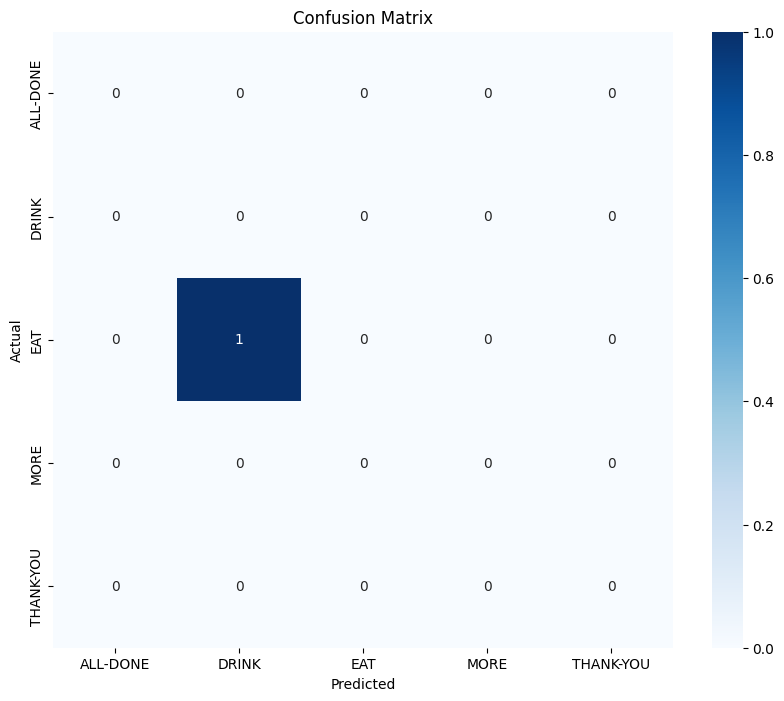

Predicted Gesture: DRINK
Recording gesture...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
['THANK-YOU']


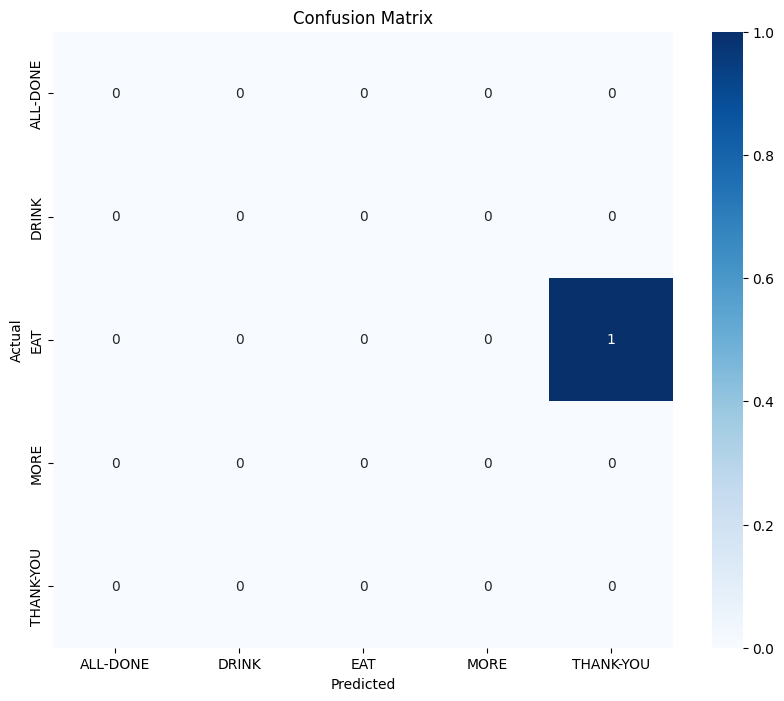

Predicted Gesture: THANK-YOU
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
['DRINK']


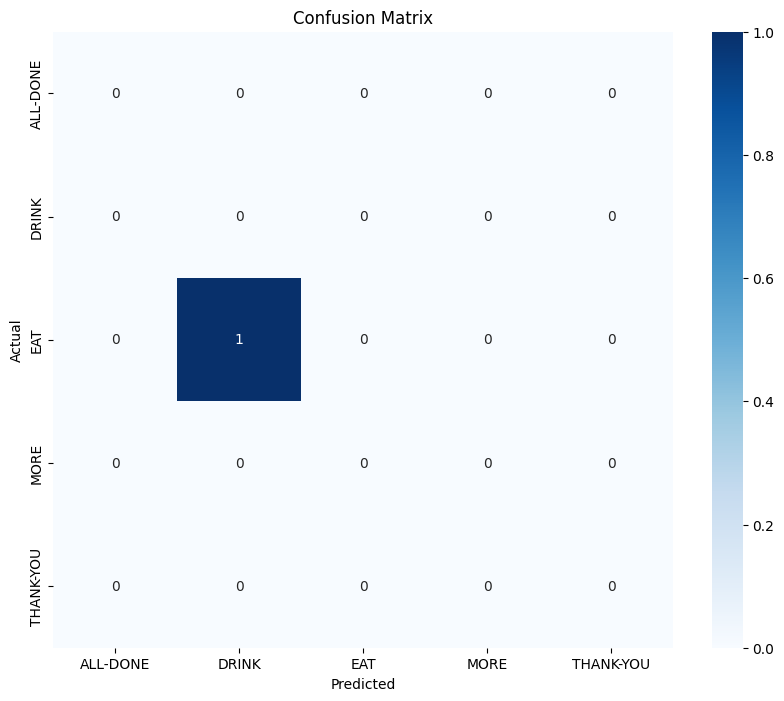

Predicted Gesture: DRINK
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
['MORE']


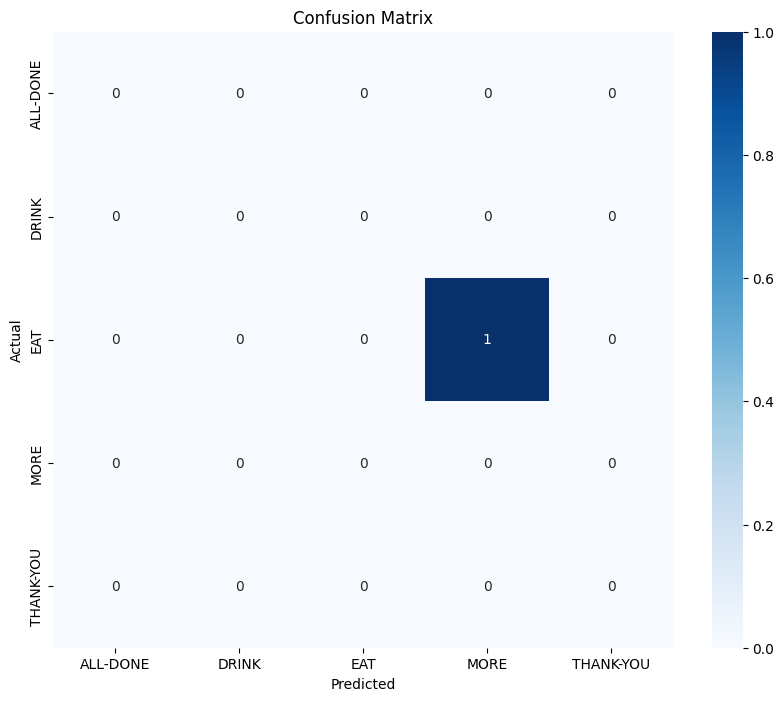

Predicted Gesture: MORE


In [6]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

frame_rate = cap.get(cv2.CAP_PROP_FPS)
frame_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
frame_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
isRecording = False
landmark_seq = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: 
        break

    image, results = mediapipe_detection(frame, holistics)
    draw_landmarks(image, results)

    if isRecording:
        holistic_landmarks = extract_keypoints(results)
        landmark_seq.append(holistic_landmarks)

    cv2.imshow("Recording Gestures", image)
    
    key = cv2.waitKey(5) & 0xFF
    if key == ord("r"):
            if not isRecording:
                isRecording = True 
                print("Recording gesture...")
    elif key == ord("s"):
        if isRecording:
            isRecording = False 

    if isRecording and len(landmark_seq) == 30: 
        pred_gesture = predict(landmark_seq, frame_rate, frame_width, frame_height)
        print(f"Predicted Gesture: {pred_gesture}")
        landmark_seq = []
    
         

    # Exit on 'q' key press
    elif key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()